In [1]:
## Install dependencies
!pip install tensorflow==1.15 dm-sonnet==1.36 tensor2tensor==1.14

## Import source code
import time
import numpy as np
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # Hide TF deprecation messages
import matplotlib.pyplot as plt
%cd /tmp
%rm -rf /tmp/deepmind_research
!git clone https://github.com/deepmind/deepmind-research.git \
  /tmp/deepmind_research
%cd /tmp/deepmind_research/polygen
import modules
import data_utils

## Download pre-trained weights
!mkdir /tmp/vertex_model
!mkdir /tmp/face_model
!gsutil cp gs://deepmind-research-polygen/vertex_model.tar.gz /tmp/vertex_model/
!gsutil cp gs://deepmind-research-polygen/face_model.tar.gz /tmp/face_model/
!tar xvfz /tmp/vertex_model/vertex_model.tar.gz -C /tmp/vertex_model/
!tar xvfz /tmp/face_model/face_model.tar.gz -C /tmp/face_model/

     |████████████████████████████████| 412.3 MB 24 kB/s 
     |████████████████████████████████| 665 kB 52.3 MB/s 
     |████████████████████████████████| 1.6 MB 58.5 MB/s 
     |████████████████████████████████| 503 kB 72.8 MB/s 
     |████████████████████████████████| 3.8 MB 27.4 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 2.5 MB 38.5 MB/s 
     |████████████████████████████████| 48 kB 6.0 MB/s 
     |████████████████████████████████| 79 kB 4.8 MB/s 
     |████████████████████████████████| 191 kB 61.0 MB/s 
     |████████████████████████████████| 5.8 MB 21.3 MB/s 
     |████████████████████████████████| 366 kB 70.0 MB/s 
     |████████████████████████████████| 367 kB 72.6 MB/s 
     |████████████████████████████████| 1.5 MB 20.1 MB/s 
     |████████████████████████████████| 1.6 MB 54.5 MB/s 
     |████████████████████████████████| 1.6 MB 53.4 MB/s 
     |████████████████████████████████| 1.6 MB 46.8 MB/s 
     |██████████████

In [2]:
vertex_module_config=dict(
  decoder_config=dict(
      hidden_size=512,
      fc_size=2048,
      num_heads=8,
      layer_norm=True,
      num_layers=24,
      dropout_rate=0.4,
      re_zero=True,
      memory_efficient=True
      ),
  quantization_bits=8,
  class_conditional=True,
  max_num_input_verts=5000,
  use_discrete_embeddings=True,
  )

face_module_config=dict(
  encoder_config=dict(
      hidden_size=512,
      fc_size=2048,
      num_heads=8,
      layer_norm=True,
      num_layers=10,
      dropout_rate=0.2,
      re_zero=True,
      memory_efficient=True,
      ),
  decoder_config=dict(
      hidden_size=512,
      fc_size=2048,
      num_heads=8,
      layer_norm=True,
      num_layers=14,
      dropout_rate=0.2,
      re_zero=True,
      memory_efficient=True,
      ),
  class_conditional=False,
  decoder_cross_attention=True,
  use_discrete_vertex_embeddings=True,
  max_seq_length=8000,
  )

tf.reset_default_graph()


# Build models
vertex_model = modules.VertexModel(**vertex_module_config)
face_model = modules.FaceModel(**face_module_config)


# Class id list
menu_list = ['0) airplane,aeroplane,plane','1) ashcan,trash can,garbage can,wastebin,ash bin,ash-bin,ashbin,dustbin,trash barrel,trash bin','2) bag,traveling bag,travelling bag,grip,suitcase','3) basket,handbasket','4) bathtub,bathing tub,bath,tub','5) bed','6) bench','7) birdhouse','8) bookshelf','9) bottle','10) bowl','11) bus,autobus,coach,charabanc,double-decker,jitney,motorbus,motorcoach,omnibus,passenger vehi','12) cabinet','13) camera,photographic camera','14) can,tin,tin can','15) cap','16) car,auto,automobile,machine,motorcar','17) cellular telephone,cellular phone,cellphone,cell,mobile phone','18) chair','19) clock','20) computer keyboard,keypad','21) dishwasher,dish washer,dishwashing machine','22) display,video display','23) earphone,earpiece,headphone,phone','24) faucet,spigot','25) file,file cabinet,filing cabinet','26) guitar','27) helmet','28) jar','29) knife','30) lamp','31) laptop,laptop computer','32) loudspeaker,speaker,speaker unit,loudspeaker system,speaker system','33) mailbox,letter box','34) microphone,mike','35) microwave,microwave oven','36) motorcycle,bike','37) mug','38) piano,pianoforte,forte-piano','39) pillow','40) pistol,handgun,side arm,shooting iron','41) pot,flowerpot','42) printer,printing machine','43) remote control,remote','44) rifle','45) rocket,projectile','46) skateboard','47) sofa,couch,lounge','48) stove','49) table','50) telephone,phone,telephone set','51) tower','52) train,railroad train','53) vessel,watercraft','54) washer,automatic washer,washing machine']
menu_map = {}
for i in menu_list:
  for j in i.split(")")[1][1:].split(","):
    menu_map[j] = i.split(")")[0]
#print(menu_map)

def get_class_id(input_str, menu_map, menu_list):
  if input_str in menu_map.keys():
    return menu_list[int(menu_map[input_str])]
  return "No match found. Please enter valid object name."

In [7]:
def polygen_output(user_input, 
                   menu_map,
                   manu_list,
                   vertex_model,
                   face_model):
  # Start process
  class_id = get_class_id(user_input, menu_map, menu_list)
  num_samples_min =  1#@param
  num_samples_batch = 8 #@param
  max_num_vertices = 400 #@param
  max_num_face_indices = 2000 #@param
  top_p_vertex_model = 0.9 #@param
  top_p_face_model = 0.9 #@param

  # Tile out class label to every element in batch
  class_id = int(class_id.split(')')[0])
  vertex_model_context = {'class_label': tf.fill([num_samples_batch,], class_id)}
  vertex_samples = vertex_model.sample(
      num_samples_batch, context=vertex_model_context, 
      max_sample_length=max_num_vertices, top_p=top_p_vertex_model, 
      recenter_verts=True, only_return_complete=True)
  vertex_model_saver = tf.train.Saver(var_list=vertex_model.variables)

  # The face model generates samples conditioned on a context, which here is
  # the vertex model samples
  face_samples = face_model.sample(
      vertex_samples, max_sample_length=max_num_face_indices, 
      top_p=top_p_face_model, only_return_complete=True)
  face_model_saver = tf.train.Saver(var_list=face_model.variables)

  # Start sampling
  start = time.time()
  print('Generating samples for',user_input)
  with tf.Session() as sess:
    vertex_model_saver.restore(sess, '/tmp/vertex_model/model')
    face_model_saver.restore(sess, '/tmp/face_model/model')
    mesh_list = []
    num_samples_complete = 0
    while num_samples_complete < num_samples_min:
      v_samples_np = sess.run(vertex_samples)
      if v_samples_np['completed'].size == 0:
        print('No vertex samples completed in this batch. Try increasing ' +
              'max_num_vertices.')
        continue
      f_samples_np = sess.run(
          face_samples,
          {vertex_samples[k]: v_samples_np[k] for k in vertex_samples.keys()})
      v_samples_np = f_samples_np['context']
      num_samples_complete_batch = f_samples_np['completed'].sum()
      num_samples_complete += num_samples_complete_batch
      print('Num. samples complete: {}'.format(num_samples_complete))
      for k in range(num_samples_complete_batch):
        verts = v_samples_np['vertices'][k][:v_samples_np['num_vertices'][k]]
        faces = data_utils.unflatten_faces(
            f_samples_np['faces'][k][:f_samples_np['num_face_indices'][k]])
        mesh_list.append({'vertices': verts, 'faces': faces})
  end = time.time()
  print('sampling time: {}'.format(end - start))

  data_utils.plot_meshes(mesh_list, ax_lims=0.4)

Generating samples for train
No vertex samples completed in this batch. Try increasing max_num_vertices.
No vertex samples completed in this batch. Try increasing max_num_vertices.
No vertex samples completed in this batch. Try increasing max_num_vertices.
Num. samples complete: 1
sampling time: 2409.348174095154


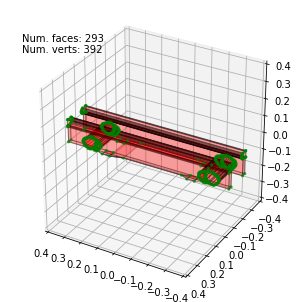

In [9]:
# Define user input
#user_inputs = ["lounge", "lamp", "remote", "video", "headphone"]
user_inputs = ["train"]
for k in user_inputs: 
  polygen_output(k, menu_map, menu_list, vertex_model, face_model)

In [ ]:
mesh_id =   0#@param
data_utils.write_obj(
    mesh_list[mesh_id]['vertices'], mesh_list[mesh_id]['faces'], 
    'mesh-{}.obj'.format(mesh_id))

In [ ]:
word_list = [("table", 10), ("plane", 2), ("grrrr", 3.5)]
word_list.sort(key = lambda x: x[1]) 
word_list

[('plane', 2), ('grrrr', 3.5), ('table', 10)]